In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os, json, heapq, operator
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from bisect import bisect, bisect_left, bisect_right
%matplotlib inline

In [4]:
base = os.path.dirname(os.getcwd())

In [6]:
price_path = os.path.join(base, 'prices')

In [50]:
s = ['19910101']*100000
import time
t = time.time()
for z in s:
    datetime.strptime(z, '%Y%m%d')
c = time.time()
print((c-t)/100000)

1.1393826007843017e-05


In [177]:
class InputManager:
    def __init__(self, reach, shift, length):
        self.R = reach
        self.S = shift
        self.L = length
        self.file_list = {f: pd.read_csv(os.path.join(price_path, f)).set_index('<DTYYYYMMDD>') for f in os.listdir(price_path) if not f.startswith('WIG')}
        self.samples = []
        self.labels = []
        self.encoding = 'R_' + str(self.R) + 'S_' + str(self.S)
        self.fatalities = 0
        
    def extract_data(self, start_date='19900101', end_date='20140101'):
        for name, file in self.file_list.items():
            dates = list(map(str, file.index))
            start_ind = bisect(dates, start_date)
            end_ind = bisect(dates, end_date)
            final = bisect(dates, (datetime.strptime(end_date, '%Y%m%d')+timedelta(days=self.R+3)).strftime('%Y%m%d'))
            if end_ind == final:
                end_ind -= self.R
            dates = dates[start_ind:final]
            dates_ind_dict = dict(zip(dates, list(range(len(dates)))))
            if len(dates) == 0 or end_ind < 0:
                continue
            
            prices = file['<CLOSE>'].as_matrix()[start_ind:final]
            
            
            self.comp_sample = []
            self.comp_labels = []
            end_date_dt = datetime.strptime(dates[end_ind-start_ind], '%Y%m%d')
            
            
            for run in range(self.S):
                try:
                    things = prices[run:]

                    current_date = datetime.strptime(dates[run], '%Y%m%d')
                    slices = []
                    respective_dates = []
                    while current_date < end_date_dt:
                        c = current_date.strftime('%Y%m%d')
                        while current_date < end_date_dt and c not in dates_ind_dict:
                            current_date += timedelta(days=1)
                            c = current_date.strftime('%Y%m%d')

                        if current_date == end_date_dt:
                            break
                        slices.append(prices[dates_ind_dict[c]])
                        respective_dates.append(dates[dates_ind_dict[c]])
                        current_date += timedelta(days=self.S)

                    for nr in range(len(slices)-self.L-1):

                        last_date = respective_dates[nr+self.L+1]
                        check_date = datetime.strptime(last_date, '%Y%m%d')+timedelta(days=self.R)
                        while check_date < end_date_dt + timedelta(days=self.R+3) and check_date.strftime('%Y%m%d') not in dates_ind_dict:
                            check_date += timedelta(days=1)

                        if check_date.strftime('%Y%m%d') not in dates_ind_dict:
                            continue
                        self.samples.append(slices[nr:nr+self.L+1])
                        result = int((prices[dates_ind_dict[check_date.strftime('%Y%m%d')]] - prices[dates_ind_dict[last_date]]) > 0)
                        if result == 1:
                            self.labels.append([0,1])
                        elif result == 0:
                            self.labels.append([1,0])
                except:
                    print('something bad happend at', name, ' while run number', run)
                    continue
        
        self.samples = np.array(self.samples)
        
    def scale(self):
        if len(self.samples)==0:
            print('no samples to preprocess')
        sample_mean = np.mean(self.samples)
        sample_std = np.std(self.samples)
        self.samples = (self.samples-sample_mean)/sample_std
        
    def diff(self, inplace=False):
        if len(self.samples)==0:
            print('no samples to preprocess')
        C = np.asarray(self.samples - np.roll(self.samples, shift=1))[:, 1:]/self.samples[:, 1:]
        if inplace:
            self.samples = C
            return
        return C
        
    def get_data(self):
        return self.samples, self.labels
                
                    
        
                
            
        


In [187]:
trials = 9
parameters = []
result_dict = {}
def convert(params):
    return 'S = ' + str(params[0]) + ", L = " + str(params[1])

while trials:
    trials -= 1
    
    params = (np.random.randint(1,8), np.random.randint(5,21))
    while params not in parameters:
        parameters.append(params)
        
    key = convert(params)
    result_dict[key] = {}
    
    print(key)
    im = InputManager(shift=params[0], length=params[1], reach=7)
    im.extract_data()
    im.diff()
    im.scale()
    print('extracting and preprocessing over')

    mean, std = np.mean(im.samples), np.std(im.samples)

    s = (im.samples - mean)/std

    s.shape

    C = np.random.permutation(s.shape[0])
    L = s.shape[0]

    X, Y = np.array(s[int(0.7*L):]), np.array(im.labels[int(0.7*L):])
    valx, valy = np.array(s[int(0.7*L):int(0.9*L)]), np.array(im.labels[int(0.7*L):int(0.9*L)])

    learning_rate=1e-3
    batch=100
    display=int(1e2)
    layer_size = 256
    iterations = int(4e3)

    input_size = X.shape[1]
    output_size = Y.shape[1]

    x = tf.placeholder('float', [None, input_size])
    y = tf.placeholder('float', [None, output_size])

    weights = {
        'layer1': tf.Variable(tf.random_normal([input_size, layer_size])),
        'out': tf.Variable(tf.random_normal([layer_size, output_size]))
    }

    biases = {
        'layer1': tf.Variable(tf.random_normal([layer_size])),
        'out': tf.Variable(tf.random_normal([output_size]))
    }

    def MLP(x, weigths, biases):
        hidden = tf.add(tf.matmul(x, weights['layer1']), biases['layer1'])
        hidden = tf.nn.relu(hidden)

        out = tf.add(tf.matmul(hidden, weights['out']), biases['out'])
        return out

    out = MLP(x, weights, biases)
    acc = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    init = tf.initialize_all_variables()

    def get_batch(x, y, batch, iteration):
        L = x.shape[0]
        start = (batch*iteration-batch)%L
        return x[start:start+batch], y[start:start+batch]

    train_costs = []
    val_costs = []
    acc_train = []
    acc_val = []

    with tf.Session() as sess:
        sess.run(init)

        for i in range(iterations):

            data, labels = get_batch(X, Y, batch, i)

            _, c = sess.run([optimizer, loss], feed_dict={x:data, y:labels})



            if i%display==0:
                ac, L = sess.run([acc,loss], feed_dict={x: valx, y:valy})
                ac_t = sess.run(acc, feed_dict={x:X, y:Y})
                train_costs.append(c)
                val_costs.append(L)
                acc_train.append(np.mean(ac_t))
                acc_val.append(np.mean(ac))
                
    result_dict[key]['train_cost'] = train_costs
    result_dict[key]['val_cost'] = val_costs
    result_dict[key]['acc_train'] = acc_train
    result_dict[key]['acc_val'] = acc_val
    
    print(key, 'finished')
    

S = 6, L = 11
something bad happend at MFO.csv  while run number 2
something bad happend at MFO.csv  while run number 3
something bad happend at MFO.csv  while run number 4
something bad happend at MFO.csv  while run number 5
something bad happend at VISTAL.csv  while run number 3
something bad happend at VISTAL.csv  while run number 4
something bad happend at VISTAL.csv  while run number 5
extracting and preprocessing over
S = 6, L = 11 finished
S = 3, L = 18
something bad happend at MFO.csv  while run number 2
extracting and preprocessing over
S = 3, L = 18 finished
S = 4, L = 13
something bad happend at MFO.csv  while run number 2
something bad happend at MFO.csv  while run number 3
something bad happend at VISTAL.csv  while run number 3
extracting and preprocessing over
S = 4, L = 13 finished
S = 7, L = 18
something bad happend at MFO.csv  while run number 2
something bad happend at MFO.csv  while run number 3
something bad happend at MFO.csv  while run number 4
something bad happe

0
1
2
3
4
5
6
7
8


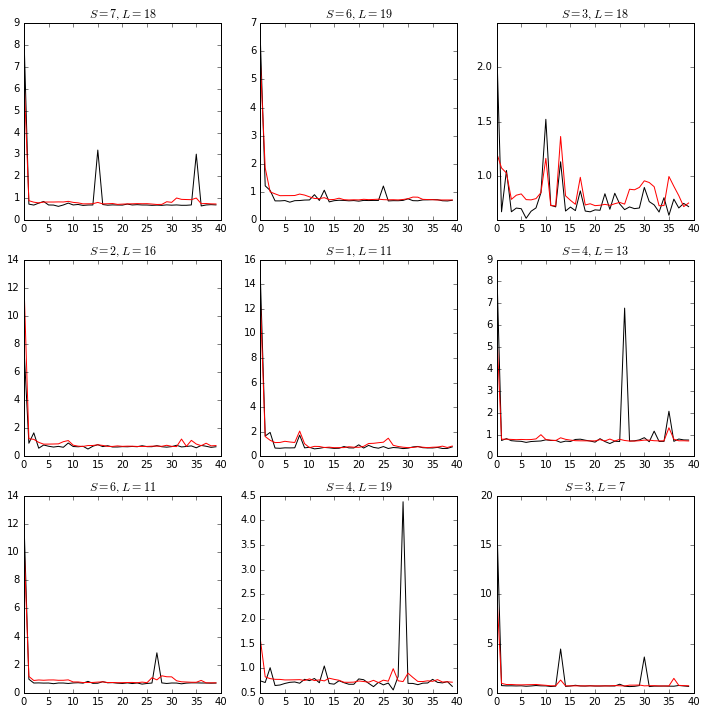

In [189]:
keys = list(result_dict.keys())
plt.figure(figsize=(12,12))
for i in range(3):
    for j in range(3):
        nr = 3*i+j
        ax = plt.subplot(3, 3, nr+1)
        thing = result_dict[keys[nr]]
        
        C = len(thing['train_cost'])
        ax.set_title('$' + keys[nr] + '$')
        acc_t = [np.mean(x) for x in thing['train_cost']]
        acc_v = [np.mean(x) for x in thing['val_cost']]
        plt.plot(np.arange(C), acc_t, c='black')
        plt.plot(np.arange(C), acc_v, c='red')
        
        
plt.show()